In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from gzbuilder_analysis import load_aggregation_results, load_fit_results

In [2]:
agg_results = load_aggregation_results('output_files/aggregation_results', ext='pkl.gz')

In [3]:
fit_results = load_fit_results('output_files/tuning_results', ext='pickle.gz')

In [4]:
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl')

In [5]:
metadata = pd.read_csv('lib/galaxy-builder-subjects.csv', index_col=0)\
    .query('subject_set_id >= 20561 and subject_set_id <= 21182')\
    ['metadata']\
    .apply(json.loads).apply(pd.Series)

dr7objid_map = metadata['SDSS dr7 id']\
    .rename('dr7objid').dropna().astype(np.int64)\
    .drop_duplicates()

fit_results = fit_results.assign(dr7objid=dr7objid_map)

In [6]:
meert_CAST__table = Table.read('../source_files/UPenn_PhotDec_CAST.fits', memmap=True)
meert_CAST = meert_CAST__table.to_pandas()
del meert_CAST__table

In [7]:
meert_r_band__table = Table.read('../source_files/UPenn_PhotDec_Models_rband.fits', memmap=True, hdu=1)
meert_r_band = meert_r_band__table.to_pandas()
del meert_r_band__table

In [8]:
def is_flagged(val, flag):
    return bool(val&(2**flag))

Specify the "intermediate catalogue"

In [9]:
# alternatively, to ensure well-fit profiles, use the "conservative catalog"
# bad_fit_mask = np.logical_and(
#     meert_r_band.finalflag.apply(lambda v: is_flagged(v, 11)).values,
#     (meert_r_band.n_bulge < 8).values,
# )

bad_fit_mask = np.logical_and(
    meert_r_band.finalflag.apply(lambda v: is_flagged(v, 10) or is_flagged(v, 11)).values,
    (meert_r_band.n_bulge <= 8).values,
)

In [10]:
meert_table = pd.concat((
    meert_r_band[bad_fit_mask],
    meert_CAST[bad_fit_mask][['ra', 'dec']],
    meert_CAST[bad_fit_mask]['objid'].rename('dr7objid'),
), axis=1)

In [11]:
n_overlap = np.isin(fit_results['dr7objid'].values.astype(np.int64), meert_table['dr7objid'].values.astype(np.int64)).sum()
print('Found {} galaxies with identical SDSS DR7 object IDs'.format(n_overlap))

Found 1 galaxies with identical SDSS DR7 object IDs


I don't trust this, so we're going to perform a match on sky position, where two galaxies within `MATCHING_THRESHOLD` arcseconds will be considered a match:

In [12]:
MATCHING_THRESHOLD = 4 # distance in arcseconds

In [13]:
gzb_coords_to_match = metadata[['ra', 'dec']].dropna()
gzb_coords = SkyCoord(*gzb_coords_to_match.values.T, unit=u.degree)
meert_coords = SkyCoord(*meert_table[['ra', 'dec']].values.T, unit=u.degree)

idx, sep, _ = match_coordinates_sky(gzb_coords, meert_coords)

In [14]:
matched_subject_ids = gzb_coords_to_match.index.values[sep.arcsecond < MATCHING_THRESHOLD]

In [15]:
matched_df = pd.concat((
    fit_results.reindex(gzb_coords_to_match.index),
    meert_table.iloc[idx].assign(subject_id=gzb_coords_to_match.index).set_index('subject_id'),
    pd.Series(sep.arcsecond, index=gzb_coords_to_match.index, name='separation'),
), axis=1).query('separation < @MATCHING_THRESHOLD')

In [16]:
matched_gzb_models = matched_df.fit_model.dropna().apply(pd.Series)

In [17]:
meert_df = meert_table\
    .iloc[idx[np.where(sep.arcsecond < MATCHING_THRESHOLD)]]\
    .assign(subject_id=matched_subject_ids)\
    .set_index('subject_id')

In [18]:
print('Position matching results in {} fits to Galaxy Builder'.format(len(meert_df)))

Position matching results in 86 fits to Galaxy Builder


In [19]:
meert_df.to_csv('lib/meert_2014.csv')

In [20]:
meert_df.columns

Index(['m_tot', 'm_aper', 'BT', 'r_tot', 'ba_tot', 'BT_aper', 'xctr_bulge',
       'xctr_bulge_err', 'yctr_bulge', 'yctr_bulge_err', 'm_bulge',
       'm_bulge_err', 'r_bulge', 'r_bulge_err', 'n_bulge', 'n_bulge_err',
       'ba_bulge', 'ba_bulge_err', 'pa_bulge', 'pa_bulge_err', 'xctr_disk',
       'xctr_disk_err', 'yctr_disk', 'yctr_disk_err', 'm_disk', 'm_disk_err',
       'r_disk', 'r_disk_err', 'n_disk', 'n_disk_err', 'ba_disk',
       'ba_disk_err', 'pa_disk', 'pa_disk_err', 'GalSky', 'GalSky_err',
       'chi2nu', 'finalflag', 'autoflag', 'pyflag', 'pyfitflag', 'ra', 'dec',
       'dr7objid'],
      dtype='object')

In [21]:
gzb_match_df = fit_results.reindex(matched_subject_ids)

In [22]:
joined_df = pd.concat((matched_gzb_models, meert_df.add_prefix('meert_'), gzb_match_df[['bulge_frac', 'bar_frac', 'r_band_luminosity', 'chisq']]), axis=1)

In [23]:
joined_df.columns

Index([          ('bar', 'c'),        ('bar', 'frac'),           ('bar', 'n'),
                 ('bar', 'q'),        ('bar', 'roll'),       ('bar', 'scale'),
            ('bulge', 'frac'),         ('bulge', 'n'),         ('bulge', 'q'),
            ('bulge', 'roll'),     ('bulge', 'scale'),      ('centre', 'mux'),
            ('centre', 'muy'),          ('disk', 'L'),         ('disk', 'Re'),
              ('disk', 'mux'),        ('disk', 'muy'),          ('disk', 'q'),
             ('disk', 'roll'),      ('spiral', 'A.0'),      ('spiral', 'A.1'),
            ('spiral', 'A.2'),      ('spiral', 'I.0'),      ('spiral', 'I.1'),
            ('spiral', 'I.2'),    ('spiral', 'phi.0'),    ('spiral', 'phi.1'),
          ('spiral', 'phi.2'), ('spiral', 'spread.0'), ('spiral', 'spread.1'),
       ('spiral', 'spread.2'),  ('spiral', 't_max.0'),  ('spiral', 't_max.1'),
        ('spiral', 't_max.2'),  ('spiral', 't_min.0'),  ('spiral', 't_min.1'),
        ('spiral', 't_min.2'),          'meert_m_tot

In [24]:
def to_mag(L):
    return 22.5 - 2.5 * np.log10(L)

In [25]:
total_magnitudes = to_mag(
    joined_df['r_band_luminosity'] * fitting_metadata.multiplier.reindex(joined_df.index)
)

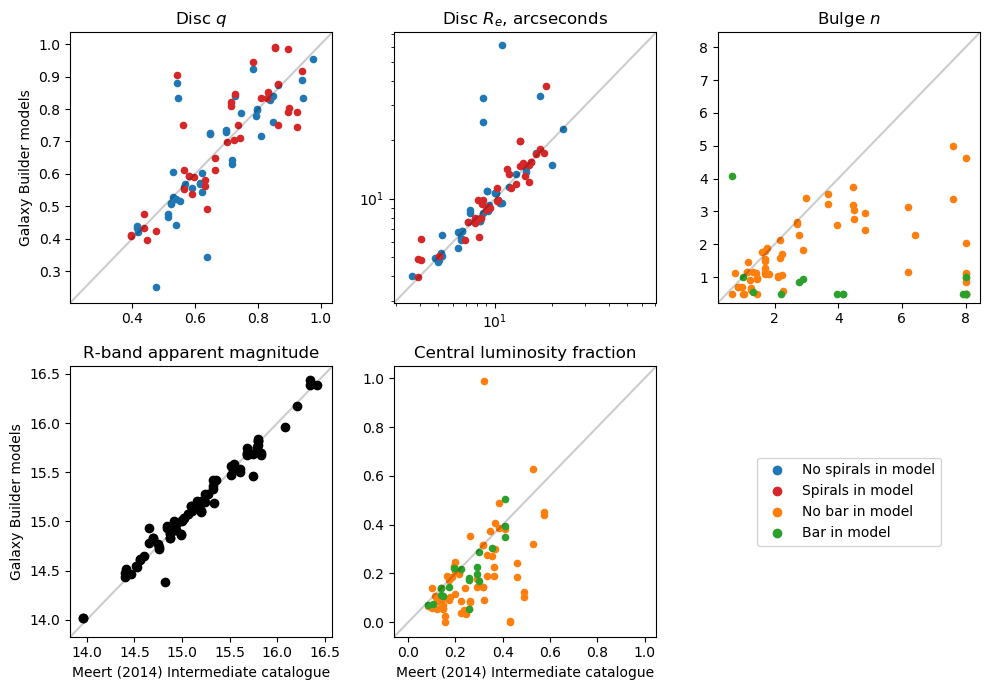

In [26]:
def add_line(ax, lim=(-10000, 10000)):
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    ax.add_line(plt.Line2D(lim, lim, c='k', alpha=0.2))
    ax_lims = min(min(xl), min(yl)), max(max(xl), max(yl))
    ax.set_xlim(*ax_lims)
    ax.set_ylim(*ax_lims)

f, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7), dpi=100)
[q_ax, re_ax, bulge_n_ax, mag_ax, bulge_frac_ax, legend_ax] = ax.ravel()

# q_ax.scatter(joined_df['meert_ba_tot'], joined_df[('disk', 'q')])
joined_df[joined_df[('spiral', 'I.0')].isna()].assign(disk_scale=lambda df: df[('disk', 'Re')] * 0.396)\
    .plot.scatter('meert_ba_tot', ('disk', 'q'), ax=q_ax, color='C0')
joined_df[joined_df[('spiral', 'I.0')].notna()].assign(disk_scale=lambda df: df[('disk', 'Re')] * 0.396)\
    .plot.scatter('meert_ba_tot', ('disk', 'q'), ax=q_ax, color='C3')

q_ax.set_xlabel('')
q_ax.set_title('Disc $q$')

# re_ax.scatter(joined_df['meert_r_disk'], joined_df[('disk', 'Re')] * 0.396)
joined_df[joined_df[('spiral', 'I.0')].isna()].assign(disk_scale=lambda df: df[('disk', 'Re')] * 0.396)\
    .plot.scatter('meert_r_disk', 'disk_scale', ax=re_ax, color='C0')
joined_df[joined_df[('spiral', 'I.0')].notna()].assign(disk_scale=lambda df: df[('disk', 'Re')] * 0.396)\
    .plot.scatter('meert_r_disk', 'disk_scale', ax=re_ax, color='C3')

re_ax.set_xscale('log')
re_ax.set_yscale('log')
re_ax.set_xlabel('')
re_ax.set_ylabel('')
re_ax.set_title('Disc $R_e$, arcseconds')

joined_df.query('bar_frac == 0').plot.scatter('meert_n_bulge', ('bulge', 'n'), color='C1', ax=bulge_n_ax)
joined_df.query('bar_frac != 0').plot.scatter('meert_n_bulge', ('bulge', 'n'), color='C2', ax=bulge_n_ax)
# bulge_n_ax.scatter(joined_df['meert_n_bulge'], joined_df[('bulge', 'n')], c='C1', marker='*')
bulge_n_ax.set_title('Bulge $n$')
bulge_n_ax.set_xlabel('')
bulge_n_ax.set_ylabel('')

mag_ax.scatter(joined_df['meert_m_tot'], total_magnitudes, c='k')
mag_ax.set_title('R-band apparent magnitude')

joined_df.query('bar_frac == 0')\
    .plot.scatter('meert_BT', 'bulge_frac', color='C1', ax=bulge_frac_ax)
joined_df.query('bar_frac != 0')\
    .eval('central_frac = bulge_frac + bar_frac')\
    .plot.scatter('meert_BT', 'central_frac', color='C2', ax=bulge_frac_ax)
# bulge_frac_ax.scatter(joined_df['meert_BT'], joined_df.eval('bulge_frac + bar_frac'), c='C1', marker='*')
bulge_frac_ax.set_title('Central luminosity fraction')
bulge_frac_ax.set_ylabel('')

q_ax.set_ylabel('Galaxy Builder models')
mag_ax.set_ylabel('Galaxy Builder models')
mag_ax.set_xlabel('Meert (2014) Intermediate catalogue')
bulge_frac_ax.set_xlabel('Meert (2014) Intermediate catalogue')
[add_line(a) for a in ax.ravel()[:-1]];

plt.sca(legend_ax)
plt.scatter([], [], c='C0', marker='o', label='No spirals in model')
plt.scatter([], [], c='C3', marker='o', label='Spirals in model')
plt.scatter([], [], c='C1', marker='o', label='No bar in model')
plt.scatter([], [], c='C2', marker='o', label='Bar in model')
plt.legend(loc='center')
plt.axis('off')

plt.tight_layout()
plt.savefig('method-paper-plots/meert-2015-comparison.pdf', bbox_inches='tight')
plt.savefig('method-paper-plots/meert-2015-comparison.png', bbox_inches='tight')